In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import pickle


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:

# Define the neural network for T
class T_Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(T_Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0)
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output is scalar T(x)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.fc3.bias, 0)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.fc2(x)
        # x = self.relu(x)
        x = self.fc3(x)
        return x
    
def KL_DV(sample_p, samples_q, net):
    T_p = net(sample_p)
    exp_T_q = torch.exp(net(samples_q))
    lower_bound = torch.mean(T_p) - torch.log(torch.mean(exp_T_q))
    return lower_bound, T_p, exp_T_q

# def Gaussian_Log_Ratio_Normalizing_Constant(cov_p, cov_q):
#     log_ratio = (np.log(np.linalg.det(cov_p)) - np.log(np.linalg.det(cov_q))) * -0.5
#     return log_ratio

def Gaussian_KL(mean_p, mean_q, cov_p, cov_q):
    KL = np.log(np.linalg.det(cov_q) / np.linalg.det(cov_p)) + np.trace(np.linalg.inv(cov_q) @ cov_p) + (mean_q - mean_p).T @ np.linalg.inv(cov_q) @ (mean_q - mean_p) - len(mean_p)
    return 0.5 * KL

def MVN_Exponential_Family_Natural_Parameter(mu,cov):
    natural_parameter1 = list(np.linalg.inv(cov) @ mu)
    natural_parameter2 = list((-0.5 * np.linalg.inv(cov)).flatten())
    natural_parameter = np.array(natural_parameter1 + natural_parameter2)
    return natural_parameter

def MVN_Exponential_Family_Sufficient_Statistics(x):
    sufficient_stat1 = list(x)
    sufficient_stat2 = list(np.outer(x,x).flatten())
    sufficient_stat = np.array(sufficient_stat1 + sufficient_stat2)
    return sufficient_stat

def MVN_Log_Ratio_Normalizing_Constant(mu_p, mu_q, cov_p, cov_q):
    ans = .5 * (np.log(np.absolute(np.linalg.det(cov_p))) - np.log(np.absolute(np.linalg.det(cov_q))) + np.dot(mu_p, np.linalg.inv(cov_p) @ mu_p) -  np.dot(mu_q, np.linalg.inv(cov_q) @ mu_q) )
    return ans

def log_ratio_normalizing_constant_KL(parameter1, parameter0,sufficient_stat_1, KL_estimate):
    estimate = np.dot((parameter1 - parameter0), sufficient_stat_1) - KL_estimate
    return estimate

def update_ema(current_ema, new_value, alpha=0.99):
    """
    Update the exponential moving average (EMA) with a new value.
    
    Parameters:
    - current_ema (torch.Tensor): The current EMA value.
    - new_value (torch.Tensor): The new value to incorporate into the EMA.
    - alpha (float): The decay rate for the EMA.

    Returns:
    - torch.Tensor: The updated EMA.
    """
    updated_ema = alpha * current_ema + (1 - alpha) * new_value
    return updated_ema


class PAndQDataset(Dataset):
    def __init__(self, samples_p, samples_q):
        """
        Initialize the dataset with samples from distributions P and Q.
        
        :param samples_p: Numpy array containing samples from distribution P.
        :param samples_q: Numpy array containing samples from distribution Q.
        """
        self.samples_p = torch.from_numpy(samples_p).float()
        self.samples_q = torch.from_numpy(samples_q).float()
    
    def __len__(self):
        """
        Return the minimum length of two distributions to keep the balance.
        """
        return min(len(self.samples_p), len(self.samples_q))
    
    def __getitem__(self, idx):
        """
        Return a sample from the dataset at the specified index.
        
        :param idx: Index of the sample to return.
        """
        return self.samples_p[idx], self.samples_q[idx]
    
def train(input_size, hidden_size, learning_rate, num_epochs, batch_size, dataset):
    net = T_Net(input_size=input_size, hidden_size=hidden_size).to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    ema_exp_T_q = torch.tensor(0)  # Initialize EMA; adjust as necessary

    losses = []
    for epoch in tqdm(range(num_epochs)):
        epoch_losses = []
        indices_p = torch.randperm(len(dataset.samples_p))
        indices_q = torch.randperm(len(dataset.samples_q))
        for (indices_batch_p, indices_batch_q) in zip(DataLoader(indices_p, batch_size=batch_size), DataLoader(indices_q, batch_size=batch_size)):
            samples_p = dataset.samples_p[indices_batch_p].to(device)
            samples_q = dataset.samples_q[indices_batch_q].to(device)
            
            optimizer.zero_grad()
            # Compute T_p and exp_T_q using the MI function
            lb, T_p, exp_T_q = KL_DV(samples_p, samples_q, net)
            # Update EMA with the mean of exp_T_q from the current batch
            with torch.no_grad():
                current_mean_exp_T_q = torch.mean(exp_T_q)
                ema_exp_T_q = update_ema(ema_exp_T_q, current_mean_exp_T_q)
            
            # Calculate the corrected loss (make sure the EMA is detached, so it is treated as a constant)
            loss = -torch.mean(T_p) + torch.mean(exp_T_q) / ema_exp_T_q.detach()
            # loss = -lb
            epoch_losses.append(loss.item()) 
            # Backpropagation
            loss.backward()
            optimizer.step()
        losses.append(sum(epoch_losses) / len(epoch_losses))
    return net, losses


# Neural Estimating the KL divergence and $\Delta$ between $\mathcal{N}(c \vec{1}, I)$ and $\mathcal{N}(-c \vec{1}, I)$

In [ ]:
res_dict = {}
for c in np.arange(1, -0.1, -0.1):
    print("c = ", c)
    mean_p = -c *np.ones(5)
    mean_q = c * np.ones(5)
    cov_p = np.eye(5)
    cov_q = np.eye(5)
    ground_truth_KL = Gaussian_KL(mean_p, mean_q, cov_p, cov_q)
    SAMPLES_P = np.random.multivariate_normal(mean_p, cov_p, 5000)
    SAMPLES_Q = np.random.multivariate_normal(mean_q, cov_q, 5000)
    dataset = PAndQDataset(SAMPLES_P, SAMPLES_Q)
    res_dict[c] = {}
    res_dict[c]['net'] = []
    res_dict[c]['losses'] = []
    res_dict[c]['KL_estimate'] = []
    print("The ground truth KL divergence is: {:.4f}".format(ground_truth_KL))
    for j in range(5):
        net,losses = train(input_size=5, hidden_size=64, learning_rate=0.0000075, num_epochs=10000, batch_size=2500, dataset=dataset)
        res_dict[c]['net'].append(net)
        res_dict[c]['losses'].append(losses)
        SAMPLES_P_tensor = torch.tensor(SAMPLES_P, dtype=torch.float32).to(device)
        SAMPLES_Q_tensor = torch.tensor(SAMPLES_Q, dtype=torch.float32).to(device)

    # Wrap the inference code in torch.no_grad() since we're not training
        with torch.no_grad():
            KL_estimate, _, _ = KL_DV(SAMPLES_P_tensor, SAMPLES_Q_tensor, net)
        res_dict[c]['KL_estimate'].append(KL_estimate.item())
        print("Iteration: ", j)
        print("The estimated KL divergence is: {:.4f}".format(KL_estimate.item()))
        
    res_dict[c]['ground_truth_KL'] = ground_truth_KL
    res_dict[c]['mean_p'] = mean_p  
    res_dict[c]['mean_q'] = mean_q
    res_dict[c]['cov_p'] = cov_p
    res_dict[c]['cov_q'] = cov_q
    res_dict[c]['SAMPLES_P'] = SAMPLES_P
    res_dict[c]['SAMPLES_Q'] = SAMPLES_Q
    print()
    

c:\Users\An Wang\.conda\envs\deep-learning\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\An Wang\.conda\envs\deep-learning\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\An Wang\.conda\envs\deep-learning\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\An Wang\.conda\envs\deep-learning\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

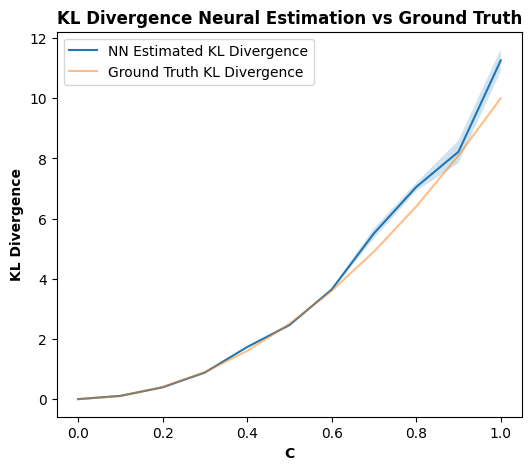

In [223]:
fig, ax = plt.subplots(figsize=(6,5))
C =  list(res_dict.keys())
kl_esimates = np.array([res_dict[c]["KL_estimate"] for c in C])
ground_truth_KLs = np.array([res_dict[c]["ground_truth_KL"] for c in C])
kl_mean = np.mean(kl_esimates, axis=1)
kl_std = np.std(kl_esimates, axis=1)
lower = kl_mean - .5 * kl_std
uper = kl_mean + .5 * kl_std
sns.lineplot(x=C, y=kl_mean, ax=ax, label="NN Estimated KL Divergence");
ax.fill_between(C, lower, uper, alpha=0.2);
sns.lineplot(x=C, y=ground_truth_KLs, ax=ax, alpha = .5,label="Ground Truth KL Divergence");
ax.set_xlabel("C", fontsize=10, fontweight='bold');
ax.set_ylabel("KL Divergence", fontsize=10, fontweight='bold');
ax.set_title("KL Divergence Neural Estimation vs Ground Truth", fontsize=12, fontweight='bold');

c:\Users\An Wang\.conda\envs\deep-learning\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\An Wang\.conda\envs\deep-learning\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\An Wang\.conda\envs\deep-learning\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\An Wang\.conda\envs\deep-learning\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

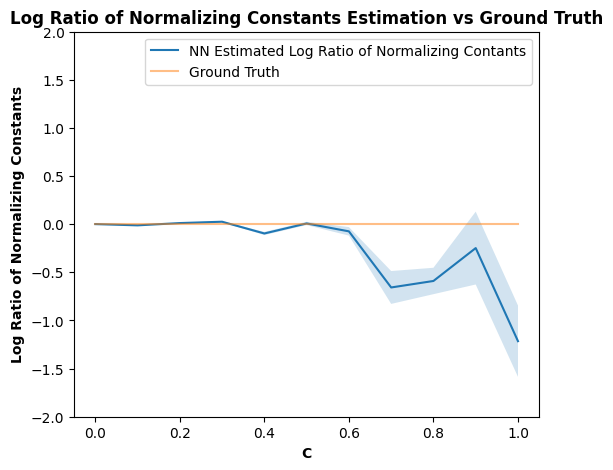

In [323]:
estimated_log_ratio_list = []
std_list = []
for idx in range(11):
    mean_p = res_dict[[key for key in res_dict.keys()][idx]]["mean_p"]
    mean_q = res_dict[[key for key in res_dict.keys()][idx]]["mean_q"]
    cov_p = res_dict[[key for key in res_dict.keys()][idx]]["cov_p"]
    cov_q = res_dict[[key for key in res_dict.keys()][idx]]["cov_q"]
    sample_p = res_dict[[key for key in res_dict.keys()][idx]]["SAMPLES_P"]
    kl_esimates = res_dict[[key for key in res_dict.keys()][idx]]["KL_estimate"]
    kl_esimates_mean = np.mean(kl_esimates)
    kl_esimates_std = np.std(kl_esimates)
    estimated_mean_suf_stat = np.mean([MVN_Exponential_Family_Sufficient_Statistics(x) for x in sample_p],axis = 0)
    estimated_log_ratio =  (MVN_Exponential_Family_Natural_Parameter(mean_p, cov_p) - MVN_Exponential_Family_Natural_Parameter(mean_q, cov_q)) @ estimated_mean_suf_stat - kl_esimates_mean
    estimated_log_ratio_list.append(estimated_log_ratio)
    std_list.append(kl_esimates_std)
estimated_log_ratio_list = np.array(estimated_log_ratio_list)
std_list = np.array(std_list)
lower = estimated_log_ratio_list - .5 * std_list
uper = estimated_log_ratio_list + .5 * std_list
fig, ax = plt.subplots(figsize=(6,5));
C =  list(res_dict.keys())
sns.lineplot(x=C, y=estimated_log_ratio_list, ax=ax, label="NN Estimated Log Ratio of Normalizing Contants");
ax.fill_between(C, lower, uper, alpha=0.2);
sns.lineplot(x=C, y=[0]*len(C), ax=ax, alpha = .5, label="Ground Truth");
ax.set_xlabel("C", fontsize=10, fontweight='bold');
ax.set_ylabel("Log Ratio of Normalizing Constants", fontsize=10, fontweight='bold');
ax.set_title("Log Ratio of Normalizing Constants Estimation vs Ground Truth", fontsize=12, fontweight='bold');
ax.set_ylim(-2,2);

In [333]:
dir_name = "Experiment1_models"
os.makedirs(dir_name)
for key,values in res_dict.items():
    sub_dir_name = str(round(key, ndigits=1))
    os.makedirs(os.path.join(dir_name,sub_dir_name))
    for i, model in enumerate(values["net"]):
        torch.save(model.state_dict(), os.path.join(dir_name,sub_dir_name,"model_{}.pth".format(i)))

In [334]:
for key,values in res_dict.items():
    del values["net"]
np.save("res_dict.npz", res_dict)

In [249]:
res_dict = np.load("res_dict.npz.npy", allow_pickle = True).item()

# Improving the Neural Estimation of KL and $\Delta$ by Path

In [ ]:
dim = 20
path = list(np.arange(0, 2.1, 0.2)) + list(np.arange(2.1, 5.1, 0.1))
MEAN = np.array([i* np.ones(dim) for i in path])
cov = np.eye(dim)
SAMPLES_path = [np.random.multivariate_normal(mean_p, cov, 5000) for mean_p in MEAN]
KL_estimates_dict = {}
for i  in range(len(path) - 1):
    print("Path: {} -> {}".format(round(path[i],ndigits=1), round(path[i+1],ndigits=1)))
    KL_estimates_dict["{} -> {}".format(round(path[i],ndigits=1), round(path[i+1],ndigits=1))] = []
    mean_p = path[i] *np.ones(dim)
    mean_q = path[i+1] * np.ones(dim)
    ground_truth_KL = Gaussian_KL(mean_p, mean_q, cov, cov)
    SAMPLES_P, SAMPLES_Q = SAMPLES_path[i], SAMPLES_path[i+1]
    dataset = PAndQDataset(SAMPLES_P, SAMPLES_Q)
    SAMPLES_P_tensor = torch.tensor(SAMPLES_P, dtype=torch.float32).to(device)
    SAMPLES_Q_tensor = torch.tensor(SAMPLES_Q, dtype=torch.float32).to(device)
    print("The ground truth KL divergence is: {:.4f}".format(ground_truth_KL))
    for j in range(3):
        net,losses = train(input_size=dim, hidden_size=64, learning_rate=0.0000075, num_epochs=10000, batch_size=2500, dataset=dataset)
        with torch.no_grad():
            KL_estimate, _, _ = KL_DV(SAMPLES_P_tensor, SAMPLES_Q_tensor, net)
        KL_estimates_dict["{} -> {}".format(round(path[i],ndigits=1), round(path[i+1],ndigits=1))].append(KL_estimate.item())
        print("The estimated KL divergence is: {:.4f}".format(KL_estimate.item()))
    # Save the dictionary
    with open('Delta_NN_Esimate_By_Path.pkl', 'wb') as file:
        pickle.dump(KL_estimates_dict, file)
    

In [3]:
KL_estimates_dict = np.load("Delta_NN_Esimate_By_Path.pkl", allow_pickle=True)


In [117]:
"""Neural KL Estimate of the Log Ratio of Normalizing Constants"""
ans = 0
wrong_ans = 0
dim = 20
path = list(np.arange(0, 2.1, 0.2)) + list(np.arange(2.1, 5.1, 0.1))
MEAN = np.array([i* np.ones(dim) for i in path])
cov = np.eye(dim)
progression = [0]
ignore_kL = [0]
true_log_ratio =  MVN_Log_Ratio_Normalizing_Constant(MEAN[0], MEAN[-1], cov, cov)
SAMPLES_path = [np.random.multivariate_normal(mean_p, cov, 5000) for mean_p in MEAN]
nat_params_init= MVN_Exponential_Family_Natural_Parameter(MEAN[-1], cov)
nat_params_end = MVN_Exponential_Family_Natural_Parameter(MEAN[0], cov)
for i, estimates in enumerate(KL_estimates_dict.values()):
    kl = np.max(estimates)
    nat_params1 = MVN_Exponential_Family_Natural_Parameter(MEAN[i], cov)
    nat_params2 = MVN_Exponential_Family_Natural_Parameter(MEAN[i+1], cov)
    suf_stat1 = np.mean([MVN_Exponential_Family_Sufficient_Statistics(SAMPLES_path[i][j]) for j in range(SAMPLES_path[i].shape[0])], axis = 0)
    log_ratio_path = log_ratio_normalizing_constant_KL(nat_params1, nat_params2, suf_stat1, kl)
    ans+= log_ratio_path
    progression.append(ans)
    wrong_ans += log_ratio_normalizing_constant_KL(nat_params1, nat_params2, suf_stat1, 0)
    ignore_kL.append(wrong_ans)


In [210]:
"""Path Sampling Estimate of the Log Ratio of Normalizing Constants"""
path_ps_unif = np.linspace(0,5, 41)
path_ps_40 = np.random.uniform(low=0.0, high=5.0, size = 40)
path_ps_500= np.random.uniform(low=0.0, high=5.0, size = 500)
path_ps_1000 = np.random.uniform(low=0.0, high=5.0, size = 1000)

path_ps_40 = np.sort(np.append(path_ps_40, np.array([0,5])))
path_ps_500 = np.sort(np.append(path_ps_500, np.array([0,5])))
path_ps_1000 = np.sort(np.append(path_ps_1000, np.array([0,5])))

MEAN_ps_unif= np.array([i* np.ones(dim) for i in path_ps_unif])
MEAN_ps_40 = np.array([i* np.ones(dim) for i in path_ps_40])
MEAN_ps_500 = np.array([i* np.ones(dim) for i in path_ps_500])
MEAN_ps_1000 = np.array([i* np.ones(dim) for i in path_ps_1000])

SAMPLES_path_unif = [np.random.multivariate_normal(mean_p, cov, 5000) for mean_p in MEAN_ps_unif]
SAMPLES_path_ps_40 = [np.random.multivariate_normal(mean_p, cov, 5000) for mean_p in MEAN_ps_40]
SAMPLES_path_ps_500 = [np.random.multivariate_normal(mean_p, cov, 5000) for mean_p in MEAN_ps_500]
SAMPLES_path_ps_1000 = [np.random.multivariate_normal(mean_p, cov, 5000) for mean_p in MEAN_ps_1000]

cov = np.eye(dim)
path_sampling_cum_unif = []
path_sampling_cum_40 = []
path_sampling_cum_500= []
path_sampling_cum_1000 = []


ans = 0
for i in range(len(SAMPLES_path_unif)):
    suf_stat_mean = np.mean([MVN_Exponential_Family_Sufficient_Statistics(SAMPLES_path_unif[i][j]) for j in range(SAMPLES_path_unif[i].shape[0])], axis = 0)
    summand = np.dot(suf_stat_mean,nat_params_end - nat_params_init) 
    ans += summand / len(SAMPLES_path_unif)
    path_sampling_cum_unif.append(ans)

ans = 0
for i in range(len(SAMPLES_path_ps_40)):
    suf_stat_mean = np.mean([MVN_Exponential_Family_Sufficient_Statistics(SAMPLES_path_ps_40[i][j]) for j in range(SAMPLES_path_ps_40[i].shape[0])], axis = 0)
    summand = np.dot(suf_stat_mean,nat_params_end - nat_params_init) 
    ans += summand / len(SAMPLES_path_ps_40)
    path_sampling_cum_40.append(ans)

ans = 0 
for i in range(len(SAMPLES_path_ps_500)):
    suf_stat_mean = np.mean([MVN_Exponential_Family_Sufficient_Statistics(SAMPLES_path_ps_500[i][j]) for j in range(SAMPLES_path_ps_500[i].shape[0])], axis = 0)
    summand = np.dot(suf_stat_mean,nat_params_end - nat_params_init) 
    ans += summand / len(SAMPLES_path_ps_500)
    path_sampling_cum_500.append(ans)

ans = 0
for i in range(len(SAMPLES_path_ps_1000)):
    suf_stat_mean = np.mean([MVN_Exponential_Family_Sufficient_Statistics(SAMPLES_path_ps_1000[i][j]) for j in range(SAMPLES_path_ps_1000[i].shape[0])], axis = 0)
    summand = np.dot(suf_stat_mean,nat_params_end - nat_params_init) 
    ans += summand / len(SAMPLES_path_ps_1000)
    path_sampling_cum_1000.append(ans)


In [214]:
path_ps_1000 = np.random.uniform(low=0.0, high=5.0, size = 1000)
path_ps_1000 = np.sort(np.append(path_ps_1000, np.array([0,5])))
MEAN_ps_1000 = np.array([i* np.ones(dim) for i in path_ps_1000])
SAMPLES_path_ps_1000 = [np.random.multivariate_normal(mean_p, cov, 5000) for mean_p in MEAN_ps_1000]
path_sampling_cum_1000 = []
ans = 0
for i in range(len(SAMPLES_path_ps_1000)):
    suf_stat_mean = np.mean([MVN_Exponential_Family_Sufficient_Statistics(SAMPLES_path_ps_1000[i][j]) for j in range(SAMPLES_path_ps_1000[i].shape[0])], axis = 0)
    summand = np.dot(suf_stat_mean,nat_params_end - nat_params_init) 
    ans += summand / len(SAMPLES_path_ps_1000)
    path_sampling_cum_1000.append(ans)

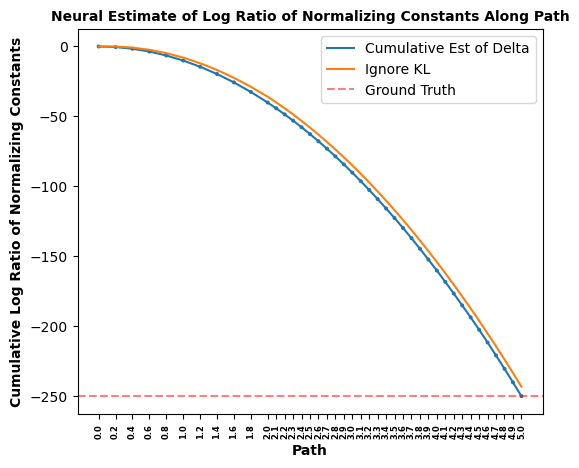

In [230]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(path, progression, label = "Cumulative Est of Delta") 
ax.plot(path, ignore_kL, label = "Ignore KL")
ax.set_xticks([round(path[i],ndigits = 1) for i in range(len(path))])
xtick_labels = [str(round(i, ndigits = 1)) for i in path]
ax.set_xticklabels(xtick_labels, rotation=90, fontsize = 6, fontweight='bold');
ax.axhline(y=true_log_ratio, color='r', linestyle='--', label = "Ground Truth", alpha = 0.5);
ax.scatter(path, progression, sizes = [3.5] * len(path));
ax.set_xlabel("Path", fontweight = "bold");
ax.set_ylabel("Cumulative Log Ratio of Normalizing Constants", fontweight = "bold");
ax.set_title("Neural Estimate of Log Ratio of Normalizing Constants Along Path", fontweight = "bold", fontsize = 10);
ax.legend(); 


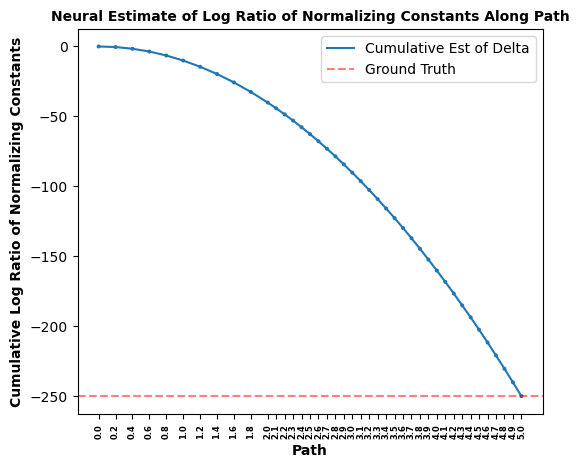

In [222]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(path, progression, label = "Cumulative Est of Delta") 
#ax.plot(path, ignore_kL, label = "Ignore KL")
ax.set_xticks([round(path[i],ndigits = 1) for i in range(len(path))])
xtick_labels = [str(round(i, ndigits = 1)) for i in path]
ax.set_xticklabels(xtick_labels, rotation=90, fontsize = 6, fontweight='bold');
ax.axhline(y=true_log_ratio, color='r', linestyle='--', label = "Ground Truth", alpha = 0.5);
ax.scatter(path, progression, sizes = [3.5] * len(path));
ax.set_xlabel("Path", fontweight = "bold");
ax.set_ylabel("Cumulative Log Ratio of Normalizing Constants", fontweight = "bold");
ax.set_title("Neural Estimate of Log Ratio of Normalizing Constants Along Path", fontweight = "bold", fontsize = 10);
ax.legend(); 


The final estimate of the path 40 is -267.7085161740798
The final estimate of the path 500 is -262.9456236938522
The final estimate of the path 1000 is -255.17539404570093


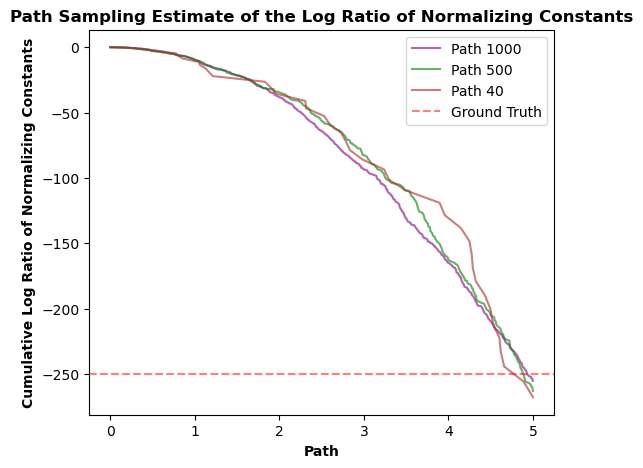

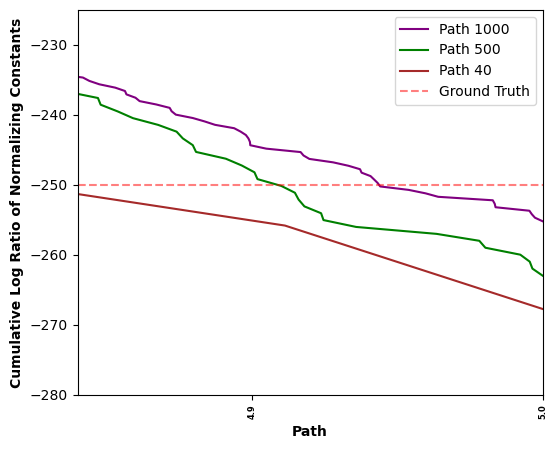

In [223]:
"""Path Sampling with Uniform Path"""
fig, ax = plt.subplots(figsize=(6,5))
#ax.plot(path_ps_unif, path_sampling_cum_unif, label = "Uniform Path 40")
ax.plot(path_ps_1000, path_sampling_cum_1000, label = "Path 1000", color = "purple", alpha = 0.6)
ax.plot(path_ps_500, path_sampling_cum_500, label = "Path 500",color = "green", alpha = 0.6) 
ax.plot(path_ps_40, path_sampling_cum_40, label = "Path 40", color = "brown", alpha = 0.6)

ax.axhline(y=true_log_ratio, color='r', linestyle='--', label = "Ground Truth", alpha = 0.5);
ax.set_xlabel("Path", fontweight = "bold");
ax.set_ylabel("Cumulative Log Ratio of Normalizing Constants", fontweight = "bold");
ax.set_title("Path", fontweight = "bold", fontsize = 10);
ax.legend(); 
ax.set_title("Path Sampling Estimate of the Log Ratio of Normalizing Constants", fontweight = "bold")



fig, ax = plt.subplots(figsize=(6,5))
ax.plot(path_ps_1000, path_sampling_cum_1000, label = "Path 1000", color = "purple")
ax.plot(path_ps_500, path_sampling_cum_500, label = "Path 500", color = "green") 
ax.plot(path_ps_40, path_sampling_cum_40, label = "Path 40", color = "brown")

ax.set_xticks([round(path_ps_unif[i],ndigits = 3) for i in range(len(path_ps_unif))])
#xtick_labels = [str(round(i, ndigits = 3)) for i in path_ps_unif]
ax.set_xticklabels(xtick_labels, rotation=90, fontsize = 6, fontweight='bold');
ax.axhline(y=true_log_ratio, color='r', linestyle='--', label = "Ground Truth", alpha = 0.5);
#ax.scatter(path_ps_unif, path_sampling_cum_unif, sizes = [3.5] * len(path));
ax.set_xlabel("Path", fontweight = "bold");
ax.set_ylabel("Cumulative Log Ratio of Normalizing Constants", fontweight = "bold");
ax.set_xlim(4.8, 5)
ax.set_ylim(-280, -225)
ax.legend(); 
print("The final estimate of the path 40 is {}".format(path_sampling_cum_40[-1]))
print("The final estimate of the path 500 is {}".format(path_sampling_cum_500[-1]))
print("The final estimate of the path 1000 is {}".format(path_sampling_cum_1000[-1]))

In [233]:
np.save("path_sampling_cum_40.npy", path_sampling_cum_40)
np.save("path_sampling_cum_500.npy", path_sampling_cum_500)
np.save("path_sampling_cum_1000.npy", path_sampling_cum_1000)

np.save("path_ps_40.npy", path_ps_40)
np.save("path_ps_500.npy", path_ps_500)
np.save("path_ps_1000.npy", path_ps_1000)